<a href="https://colab.research.google.com/github/ajinkyagorad/Binance/blob/main/notebooks/SeaICE_detection_%5BDetectron_2_Panoptic%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install Detectron2

In [2]:
# code from https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5
# https://detectron2.readthedocs.io/en/latest/tutorials/getting_started.html


!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'detectron2' already exists and is not an empty directory.
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Load sea ice data and train 
* COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml

In [5]:
import scipy.io
import json
import numpy as np
label_def_path = '/content/drive/MyDrive/PhD/Maritime/SeaICE/EhrensvardData/label_def.txt'
with open(label_def_path) as f:
  categories = f.read().split('\n')
print(categories)


['seaice', 'sky', 'water', 'vegetation']


In [6]:
dataset_path = '/content/drive/MyDrive/PhD/Maritime/SeaICE/EhrensvardData/'
import glob
a=glob.glob(dataset_path+'labels/*.png')
a[0].split('/')[-1]

'1643970853464848000.png'

In [7]:
from detectron2.structures import BoxMode

def get_data_dict(path):
    flist_label = glob.glob(path+'labels/*.png')
    ignorefiles=[]
    with open(path+'labels/corrupted.txt') as f:
      ignorefiles.append(f.read())
    
    # get list of corresponding data files
    flist_data = glob.glob(path+'images/*.png')
    # get image size from single sample
    print(path)
    I = cv2.imread(flist_data[0])
    height,width = I.shape[0],I.shape[1]
    dataset=[]
    for n,flabel in enumerate(flist_label):
      if flabel[0].split('/')[-1] not in ignorefiles:
        el = dict()
        el['image_id'] = n #f.split('/')[-1].split('.')[0]
        el['height'] = height
        el['width'] = width
        el['file_name'] = flist_data[n]
        el['sem_seg_file_name']=flist_label[n]
        dataset.append(el)
    return dataset


In [8]:
# register train and test dataset
DatasetCatalog.register("Ehrensvard_SeaICE",lambda d:get_data_dict(dataset_path))
MetadataCatalog.get("Ehrensvard_SeaICE").set(stuff_classes=categories)


Metadata(name='Ehrensvard_SeaICE', stuff_classes=['seaice', 'sky', 'water', 'vegetation'])

### Show some images from train dataset

/content/drive/MyDrive/PhD/Maritime/SeaICE/EhrensvardData/


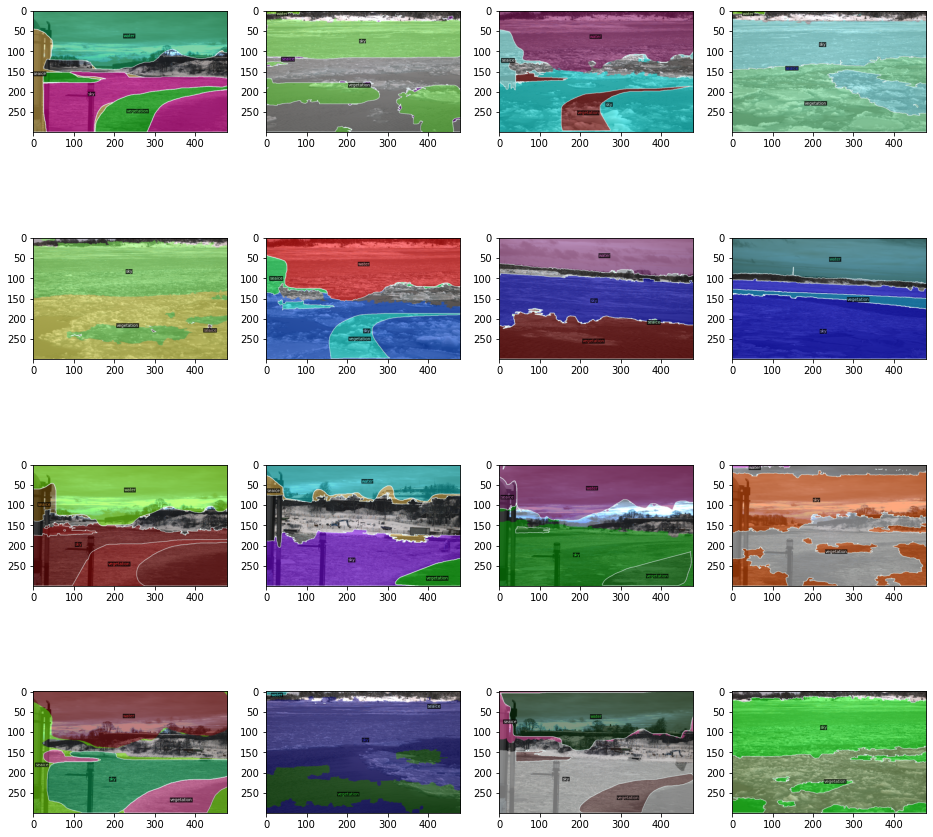

In [9]:
from PIL import Image
dataset_dicts = get_data_dict(dataset_path)
metadata=MetadataCatalog.get("Ehrensvard_SeaICE")
from matplotlib import pyplot as plt
fig,axs=plt.subplots(4,4,figsize=(16,16))
axs=axs.flatten()
for i,d in enumerate(random.sample(dataset_dicts, 16)):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    im=Image.fromarray(out.get_image()[:, :, ::-1])
    axs[i].imshow(out.get_image()[:, :, ::-1])
    i=i+1
plt.show()

### Train the RetinaNet model

In [10]:
from detectron2.engine import DefaultTrainer
# https://detectron2.readthedocs.io/
cfg = get_cfg()
print(cfg.OUTPUT_DIR)
modelyaml = 'COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml' # e.g. "COCO-PanopticSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(modelyaml))
cfg.DATASETS.TRAIN = ("Ehrensvard_SeaICE",)
cfg.DATASETS.TEST = ("Ehrensvard_SeaICE")
cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(modelyaml)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 8   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(categories)   # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

./output


RuntimeError: ignored